#### Question

Report the best hypermeters which used to run Random Forest algorithm. Explain your results.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Creditability       1000 non-null   int64 
 1   Acc_Bal_bin         1000 non-null   object
 2   Pay_Status_bin      1000 non-null   object
 3   Value_SavStock_bin  1000 non-null   object
 4   Length_Emp_bin      1000 non-null   object
 5   S&M_Status_bin      1000 non-null   object
 6   No_of_Credits_bin   1000 non-null   object
 7   Co_Credits_bin      1000 non-null   object
 8   Purpose_bin         1000 non-null   object
 9   Telephone_bin       1000 non-null   object
 10  Instalment_bin      1000 non-null   object
 11  Apartment_bin       1000 non-null   object
 12  Most_Val_Asset_bin  1000 non-null   object
 13  Duration_Credit     1000 non-null   int64 
 14  Credit_Amount       1000 non-null   int64 
 15  Age_bin             1000 non-null   object
dtypes: int64(3), object(13)
m

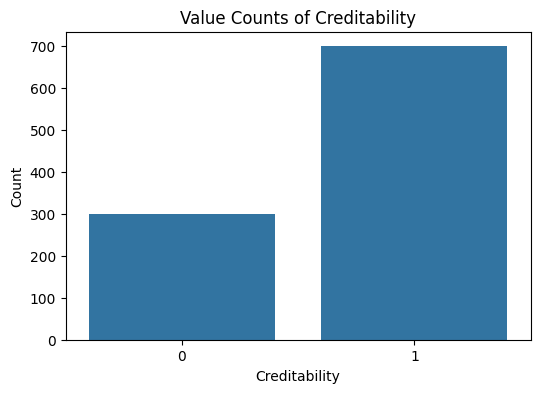

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('german_data_creditcard.csv')

print(df.info())
plt.figure(figsize=(6, 4))
sns.countplot(x='Creditability', data=df)
plt.title('Value Counts of Creditability')
plt.xlabel('Creditability')
plt.ylabel('Count')
plt.show()


Pre-processing

In [48]:
df_encode = pd.get_dummies(df, drop_first=True)
print(df_encode.head())

   Creditability  Duration_Credit  Credit_Amount  Acc_Bal_bin_b. no balance  \
0              1               18           1049                      False   
1              1                9           2799                      False   
2              1               12            841                       True   
3              1               12           2122                      False   
4              1               12           2171                      False   

   Acc_Bal_bin_c. some balance  Pay_Status_bin_b. paid up  \
0                        False                      False   
1                        False                      False   
2                        False                       True   
3                        False                      False   
4                        False                      False   

   Pay_Status_bin_c. no problem  Value_SavStock_bin_b. >= 100 DM  \
0                          True                            False   
1                     

Split the data into train and test sets

In [49]:
# features and target

X = df_encode.drop('Creditability', axis=1)

y = df_encode['Creditability']


# train and test sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=0.7,
    random_state=42,
    stratify=y
)

print(X_train.shape, X_test.shape)

(700, 21) (300, 21)


Training the Model with train data


In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

classifier_rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    oob_score=True
)

classifier_rf.fit(X_train, y_train)

classifier_rf.oob_score_

0.7228571428571429

Predictions

In [51]:
y_pred = classifier_rf.predict(X_test)

from sklearn.metrics import precision_score

# Precision
precision = precision_score(y_test, y_pred)
print("Precision is:", precision)

Precision is: 0.7661290322580645


To get the predictions with only true positives tune with precision

In [52]:
from sklearn.metrics import classification_report, confusion_matrix

# Base model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Parameter grid
params = {
    'max_depth': [ 8, 10, 12, 15, 20, None],
    'min_samples_leaf': [ 4, 8, 10, 12],
    'n_estimators': [100, 300, 500, 600],
    'class_weight': ['balanced']
}

# Instantiate GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='precision'
)

# Fit on training data
grid_search.fit(X_train, y_train)

# Best results
print("Best Parameters:", grid_search.best_params_)
print("Best CV Precision:", grid_search.best_score_)

# Evaluate best model on test data
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

test_precision = precision_score(y_test, y_pred)
print("Test Precision:", classification_report(y_test, y_pred))


Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Parameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 12, 'n_estimators': 600}
Best CV Precision: 0.868371554853893
Test Precision:               precision    recall  f1-score   support

           0       0.57      0.70      0.63        90
           1       0.86      0.77      0.81       210

    accuracy                           0.75       300
   macro avg       0.71      0.74      0.72       300
weighted avg       0.77      0.75      0.76       300



In [53]:
print("Confusion Matrix for Random Forest:\n", confusion_matrix(y_test, y_pred))

Confusion Matrix for Random Forest:
 [[ 63  27]
 [ 48 162]]


## Conclusions

Best hypermeters are <br>
 'max_depth': 10,<br>
 'min_samples_leaf': 12,<br>
 'n_estimators': 600<br>
<br>

- The model is performing best when it's more constrained like shallow trees and more samples per leaf.

- When tried with more depth and less samples per leaf, precision was around 0.74 - 0.76

- And when tried with more trees the model became more stable(with 500, 600 etc.)

- Since I'm using the precision scoring the credibility is trustworthy, takes only true positives. And have a precision of 0.868

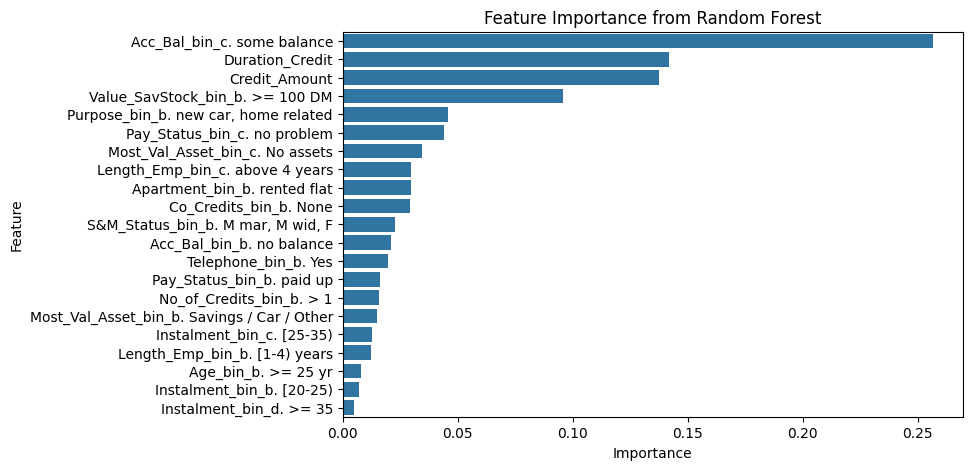

In [54]:
imp_df = pd.DataFrame({
    'Varname': X_train.columns,
    'Imp': best_model.feature_importances_
})

imp_df = imp_df.sort_values(by='Imp', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x='Imp', y='Varname', data=imp_df)
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()